In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

from scipy import optimize

In [2]:
from monk import nb, prep, pair, render, utils, grid
import freud

# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"].append(r'\usepackage{xfrac}')

In [3]:
project: signac.Project = signac.get_project()

## Measure fragility

get relaxation times from systems

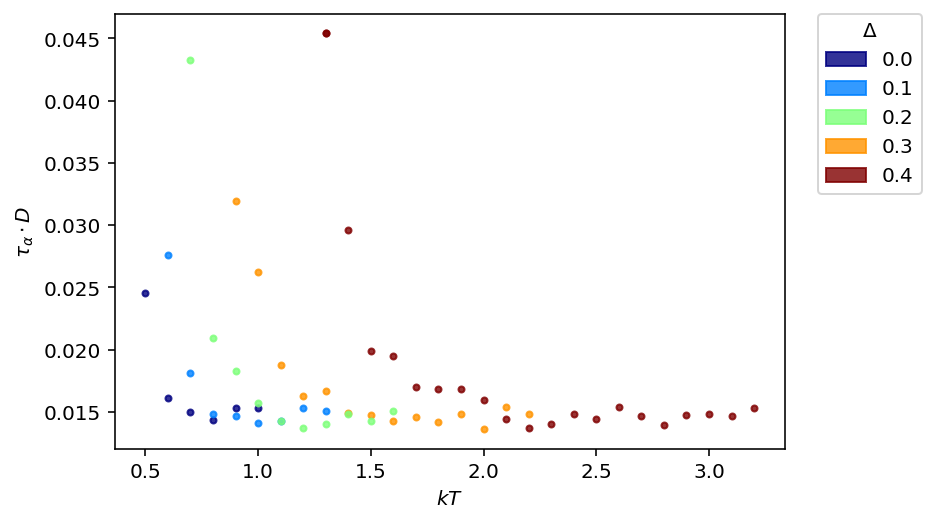

In [33]:

plt.figure()

_alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=4)
_colors = [cmap(norm(i)) for i in range(5)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=_alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project.find_jobs({"version": {'$exists': False}})):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    if delta > 0.45:
        continue

    with job:
        sims = sorted(glob.glob("*equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"{_temp_str}/alphas"][-3:])
                if alpha < 1:
                    continue
                D = np.mean(job.data[f"{_temp_str}/Ds"][-3:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                
        # print(temps, alphas)
        plt.plot(temps, np.array(Ds)*np.array(alphas), ".", color=_colors[int(round(delta / 0.1))], alpha=_alpha)

plt.xlabel(r"$kT$")
plt.ylabel(r"$\tau_{\alpha} \cdot D$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   

[0.22306678 3.45924636 0.88032364] [[ 4.63025680e-05 -3.78363538e-04  3.89843988e-05]
 [-3.78363538e-04  3.34983833e-03 -3.59767259e-04]
 [ 3.89843988e-05 -3.59767259e-04  4.05262628e-05]]
0.9958876108803554
[0.2256857  1.78164477 0.48130709] [[ 1.20627129e-04 -4.63742575e-04  4.48042864e-05]
 [-4.63742575e-04  1.90402823e-03 -1.90323683e-04]
 [ 4.48042864e-05 -1.90323683e-04  1.97421081e-05]]
0.540826976518658
[0.23742067 1.32974077 0.39482042] [[ 7.75605960e-05 -2.47439679e-04  2.89339850e-05]
 [-2.47439679e-04  8.29802799e-04 -9.97629847e-05]
 [ 2.89339850e-05 -9.97629847e-05  1.23495788e-05]]
0.43924342514817616
[0.25974785 1.0241696  0.32619208] [[ 7.37209563e-05 -1.69904990e-04  2.09471289e-05]
 [-1.69904990e-04  4.05835269e-04 -5.10833199e-05]
 [ 2.09471289e-05 -5.10833199e-05  6.56507832e-06]]
0.3604067846297127
[0.25355596 2.21563542 0.65332387] [[ 1.81971788e-04 -9.79127474e-04  1.22928823e-04]
 [-9.79127474e-04  5.59282124e-03 -7.26409076e-04]
 [ 1.22928823e-04 -7.26409076e-

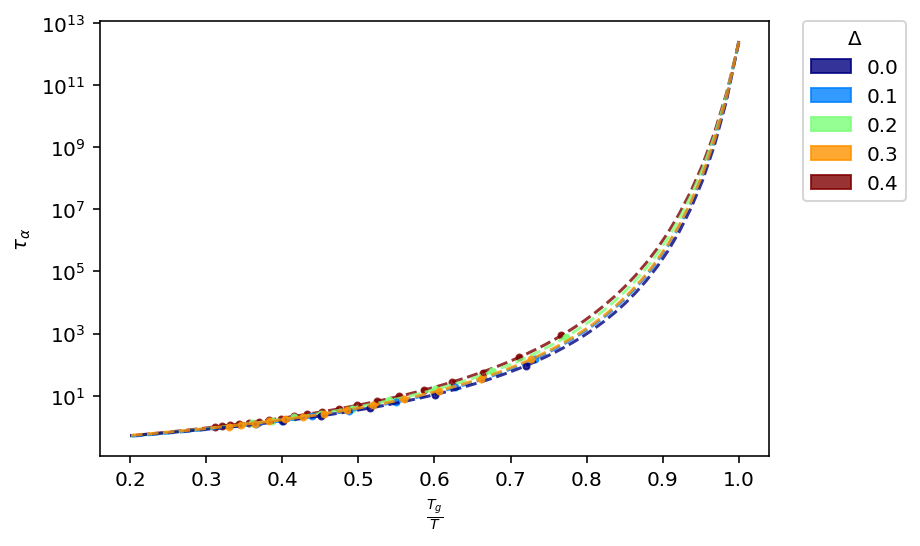

In [10]:
def vft(x, a, b, t):
    return a * np.exp(b/(x-t))

def log_vft(x, a, b, t):
    return np.log(vft(x, a, b, t))

def inv_vft(y, a, b, t):
    # y = a * np.exp(b/(x-t))
    # np.log(y) = np.log(a) + b/(x-t)
    # np.log(y) - np.log(a) = b/(x-t)
    # x - t = b/(np.log(y) - np.log(a))
    return b/np.log(y/a) + t

_alpha = .8
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=4)
_colors = [cmap(norm(i)) for i in range(5)]
_legend = [mpl.patches.Patch(color=c, label=f"{d:.1f}", alpha=_alpha) for c, d in zip(_colors, np.linspace(0.0, 0.5, 6))]

for i, job in enumerate(project.find_jobs({"version": {'$exists': False}})):
    if job.sp["seed"] > 5:
        continue

    delta = job.sp["delta"]
    if delta > 0.45:
        continue

    with job:
        sims = sorted(glob.glob("*equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"{_temp_str}/alphas"][-5:])
                if alpha < 1:
                    continue
                D = np.mean(job.data[f"{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                
        # print(temps, alphas)
        alphas = np.log(np.array(alphas[:-1]))
        temps = np.array(temps)[:-1]
        popt, pcov = optimize.curve_fit(log_vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = inv_vft(popt[0]*10e12, *popt)
        # tg = np.min(temps)/2
        print(popt, pcov)
        x = np.geomspace(tg*1.0, tg*5, 100)
        y = log_vft(x, *popt)
        print(tg)
        plt.plot(tg/x, np.exp(y), "--", color=_colors[int(round(delta / 0.1))], alpha=_alpha)
        plt.plot(tg/temps, np.exp(alphas), ".", color=_colors[int(round(delta / 0.1))], alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")
plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   

In [26]:
popt

array([0.23370674, 3.33095204, 0.89489446])